In [1]:
!pip install albumentations==1.3.0
!pip install pytorch_lightning
!pip install comet-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 13.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 10.2 MB/s 
     |████████████████████████████████| 529 kB 15.9 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=c0d146150e8ee9e46c60d945e300dd5ee052e38a0f5f1b51bc3c3d76167b49ee
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import argparse
import importlib
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import random
import cv2
from tqdm.auto import tqdm
# from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger, CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import models
import time
import copy

## Utils

In [5]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
def eer_metric(y_truth, y_pred):
    fpr, tpr, threshold = roc_curve(y_truth, y_pred, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer, fpr, fnr, eer_threshold

## Load data

In [7]:
class LivenessDataset(Dataset):
    def __init__(self, cfg, df, video_dir, transforms):
        self.cfg = cfg
        self.df = df.reset_index(drop=True)
        self.video_dir = video_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        row = self.df.iloc[item]
        vid_name = row['fname']
        vid_path = os.path.join(self.video_dir, vid_name)
        cap = cv2.VideoCapture(vid_path)
        frame_no = np.random.choice(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 1, replace=False)
        cap.set(1, frame_no[0])  # Where frame_no is the frame you want
        ret, im = cap.read()
        if len(im) == 0:
            assert False
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_ts = self.transforms(image=im)['image'].float()
        if 'liveness_score' in self.df.columns:
            label = torch.tensor(row['liveness_score']).float()
        else:
            label = -1
        return im_ts, label

## Model

In [8]:
class LivenessModel(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.backbone = models.efficientnet_v2_l(pretrained=True)
        clf_in_feature = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(clf_in_feature, 1)
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self, X):
        return  self.backbone(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = AdamW(self.backbone.parameters(), lr=self.cfg.init_lr, eps=self.cfg.eps, betas=self.cfg.betas)
        num_train_steps = int(self.cfg.num_train_examples / self.cfg.batch_size * self.cfg.epochs)

        lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_train_steps, eta_min=self.cfg.min_lr)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
            },
        }

    def step(self, X, y):
        X = X.to(self.device)
        y = y.to(self.device)
        y_pred = self(X).view(-1)
        loss = self.criterion(y_pred, y)
        return loss, y_pred

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        loss, y_pred = self.step(X, y)
        self.log('train_loss', loss)
        return {'loss': loss, 'preds':y_pred, 'labels':y}

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        loss, y_pred = self.step(X, y)
        self.log('val_loss', loss)
        y_prob = y_pred.sigmoid()
        return {'loss': loss, 'preds':y_prob, 'labels':y}

    def predict_step(self, test_batch, batch_idx):
        X = test_batch[0]
        X = X.to(self.device)
        y_pred = self(X).view(-1)
        y_prob = y_pred.sigmoid()
        return y_prob

    def compute_metrics(self, outputs):
        all_preds = np.concatenate([out['preds'].detach().cpu().numpy() for out in outputs])
        all_labels = np.concatenate([out['labels'].detach().cpu().numpy() for out in outputs])
        all_preds = (all_preds > 0.5).astype(int)
        acc = float(accuracy_score(y_true=all_labels, y_pred=all_preds))
        return acc

    def training_epoch_end(self, training_step_outputs):
        train_acc = self.compute_metrics(training_step_outputs)
        self.log('train_acc', train_acc)
        
    def validation_epoch_end(self, validation_step_outputs):
        val_acc = self.compute_metrics(validation_step_outputs)
        self.log('val_acc', val_acc)

## Training

In [ ]:
def train(cfg, df):
    for valid_fold in cfg.run_folds:
        print(f'================= Training fold {valid_fold} ================')
        seed_torch(cfg.seed) # set seed each time a fold is run

        train_df = df[df['fold']!=valid_fold].reset_index(drop=True)
        valid_df = df[df['fold']==valid_fold].reset_index(drop=True)

        if(cfg.sample):
            train_df = train_df.sample(cfg.sample).reset_index(drop=True)
            valid_df = valid_df.sample(cfg.sample).reset_index(drop=True)

        cfg.num_train_examples = len(train_df)

        # Defining DataSet
        train_dataset = LivenessDataset(cfg, train_df, cfg.video_dir, cfg.train_transforms)
        valid_dataset = LivenessDataset(cfg, valid_df, cfg.video_dir, cfg.val_transforms)

        batch_size = cfg.batch_size
        train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,
                                                pin_memory=True,drop_last=True,num_workers=cfg.num_workers)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,num_workers=cfg.num_workers,
                                                shuffle=False,pin_memory=True,drop_last=False)

        cfg.steps_per_epoch = int(len(train_df) / cfg.batch_size)
        cfg.num_train_steps = int(len(train_df) / cfg.batch_size * cfg.epochs)
        lit_module = LivenessModel(cfg)

        # logger = CSVLogger(cfg.output_dir, name=f'fold{valid_fold}')
        logger = CometLogger(api_key=cfg.comet_api_key, project_name=cfg.comet_project_name, experiment_name=cfg.output_dir_name + f'_fold{valid_fold}')
        lr_monitor = LearningRateMonitor(logging_interval='epoch')
        checkpointer = ModelCheckpoint(
            dirpath=os.path.join(cfg.output_dir, f'fold{valid_fold}'),
            filename='{epoch}-{val_loss:.3f}-{val_acc:.3f}',
            monitor='val_loss',
            verbose=True,
            save_weights_only=True
        )
        trainer = Trainer(default_root_dir=cfg.output_dir, precision=16, max_epochs=cfg.epochs,
                        check_val_every_n_epoch=1, enable_checkpointing=True,
                        log_every_n_steps=cfg.steps_per_epoch,
                        logger=logger,
                        callbacks=[lr_monitor, checkpointer],
                        accelerator=cfg.accelerator, devices=1)
        trainer.fit(lit_module, train_loader, valid_loader)
        # break

## Runing

In [9]:
class dotdict(dict):
    """ dot.notation access to dictionary attributes """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [10]:
root_folder = '/content/drive/MyDrive/ZaloAI_2022/LivenessDetection'
cfg = {
    'root_folder': '/content/drive/MyDrive/ZaloAI_2022/LivenessDetection',
    'run_folds': [0, 1], 
    'accelerator': 'gpu', 
    'devices': 'cuda',
    'comet_api_key': 'XlgNWw0MV9ThHRKRSxLMcfNo3', 
    'comet_project_name': 'Zalo22Liveness',
    'im_size': 224, 
    'num_workers': 0,
    'gradient_checkpointing': False, 
    'scheduler': 'cosine',
    'batch_scheduler': True,
    'num_cycles': 0.5, 
    'num_warmup_steps': 0,
    'epochs': 20,
    'init_lr': 1e-4,
    'min_lr': 1e-6,
    'eps': 1e-6, 
    'betas': (0.9, 0.999),
    'batch_size': 32,
    'weight_decay': 0.01,
    'gradient_accumulation_steps': 1,
    "max_grad_norm": 1000,
    "seed": 42,
    'sample': None,
    'patience': 10,
    'metadata_file': f'{root_folder}/Dataset/train/identified_metadata.csv',
    'video_dir': f'{root_folder}/Dataset/train/videos',
    'model_dir': f'{root_folder}/models',
    }

cfg = dotdict(cfg)

In [11]:
# data augmentation and transformations
cfg.train_transforms = A.Compose(
        [
            A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5),

            A.Resize(height=cfg.im_size, width=cfg.im_size, always_apply=True),
            A.OneOf(
                [A.CoarseDropout(max_height=16, max_width=16, max_holes=8, p=1), # several small holes
                A.CoarseDropout(max_height=64, max_width=64, max_holes=1, p=1),], # 1 big hole
                p=0.3
            ),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(always_apply=True),
        ],
        p=1.0,
        
    )

In [12]:
cfg.val_transforms = A.Compose(
        [
            A.Resize(height=cfg.im_size, width=cfg.im_size, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(always_apply=True),
        ],
        p=1.0,
       
    )

In [ ]:
df = pd.read_csv(cfg.metadata_file)

In [ ]:
df

,fname,liveness_score,set,knn_queries,individual_id,individual_name,fold
0,1.mp4,0.0,train,"[(108, 0.24212176, 1.0), (11, 0.25579798, 1.0)...",0,Hồng Oanh,9.0
1,2.mp4,1.0,train,"[(485, 0.023995936, 1.0), (593, 0.29561955, 0....",1,Vĩnh Hưng,4.0
2,3.mp4,1.0,train,"[(944, 0.22763091, 1.0), (987, 0.2309981, 1.0)...",2,Hoàn Vũ,1.0
3,5.mp4,0.0,train,"[(1500, 0.026418447, nan), (566, 0.09758127, 0...",3,Vĩnh Luân,5.0
4,7.mp4,1.0,train,"[(731, 0.22429407, 1.0), (189, 0.24795604, 1.0...",4,Hà Hải,6.0
...,...,...,...,...,...,...,...
1832,159.mp4,NaN,public_test_2,"[(1923, 0.011777043, nan), (1628, 0.08052045, ...",1070,Nguyên Khôi,NaN
1833,165.mp4,NaN,public_test_2,"[(1541, 0.09141338, nan), (1629, 0.097121716, ...",259,Anh Khôi,NaN
1834,171.mp4,NaN,public_test_2,"[(1842, 0.03968519, nan), (1320, 0.061653078, ...",594,Bình Dân,NaN
1835,213.mp4,NaN,public_test_2,"[(1924, 0.01797378, nan), (1728, 0.05430603, n...",483,Công Sinh,NaN


In [ ]:
df_train = df[df['set']=="train"].reset_index(drop=True)

In [ ]:
cfg.output_dir_name = "efficientnet_v2_l" 
cfg.output_dir = os.path.join(cfg.model_dir, cfg.output_dir_name)
if not os.path.exists(cfg.output_dir):
    os.makedirs(cfg.output_dir, exist_ok=True)

In [ ]:
train(cfg, df_train)

================= Training fold 0 ================


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 117 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
234.471   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/lehanh19/zalo22liveness/db22eedb8e7a455f9a4c7611764e91ea



Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 28: 'val_loss' reached 0.28641 (best 0.28641), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=0-val_loss=0.286-val_acc=0.906.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 56: 'val_loss' reached 0.18692 (best 0.18692), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=1-val_loss=0.187-val_acc=0.927.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 84: 'val_loss' reached 0.13862 (best 0.13862), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=2-val_loss=0.139-val_acc=0.948.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 112: 'val_loss' reached 0.13450 (best 0.13450), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=3-val_loss=0.135-val_acc=0.948.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 140: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 168: 'val_loss' reached 0.10116 (best 0.10116), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=5-val_loss=0.101-val_acc=0.969.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 196: 'val_loss' reached 0.09422 (best 0.09422), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=6-val_loss=0.094-val_acc=0.948.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 224: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 252: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 280: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 308: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 336: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 364: 'val_loss' reached 0.05939 (best 0.05939), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=12-val_loss=0.059-val_acc=0.979.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 392: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 420: 'val_loss' reached 0.05790 (best 0.05790), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=14-val_loss=0.058-val_acc=0.979.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 448: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 476: 'val_loss' reached 0.05463 (best 0.05463), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=16-val_loss=0.055-val_acc=0.979.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 504: 'val_loss' reached 0.02902 (best 0.02902), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=17-val_loss=0.029-val_acc=1.000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 532: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 560: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/lehanh19/zalo22liveness/db22eedb8e7a455f9a4c7611764e91ea
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [20]   : (9.972401766749413e-05, 0.0001)
COMET INFO:     train_acc [20]  : (0.6975446343421936, 0.9910714030265808)
COMET INFO:     train_loss [20] : (0.0072958702221512794, 0.3938806653022766)
COMET INFO:     val_acc [20]    : (0.90625, 1.0)
COMET INFO:     val_loss [20]   : (0.02901623398065567, 0.2864128649234772)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : efficientnet_v2_l_fold

================= Training fold 1 ================


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/lehanh19/zalo22liveness/feb9eb5f49e24d2c83f5e393fb0db564



Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 28: 'val_loss' reached 0.39235 (best 0.39235), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold1/epoch=0-val_loss=0.392-val_acc=0.860.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 56: 'val_loss' reached 0.25009 (best 0.25009), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold1/epoch=1-val_loss=0.250-val_acc=0.910.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 84: 'val_loss' reached 0.17134 (best 0.17134), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold1/epoch=2-val_loss=0.171-val_acc=0.950.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 112: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 140: 'val_loss' reached 0.13608 (best 0.13608), saving model to '/content/drive/.shortcut-targets-by-id/1V9WaGFw0duqpAxmlFQnpVCKwh6cXtbgF/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold1/epoch=4-val_loss=0.136-val_acc=0.950.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 168: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 196: 'val_loss' was not in top 1


## Predict

In [13]:
cfg.weight = "/content/drive/MyDrive/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/fold0/epoch=17-val_loss=0.029-val_acc=1.000.ckpt"
cfg.test_video_dir = "/content/drive/MyDrive/ZaloAI_2022/LivenessDetection/Dataset/public/videos"

In [14]:
model = LivenessModel.load_from_checkpoint(cfg.weight, cfg=cfg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

In [15]:
# Choose frames at each vid to infer
fnames = os.listdir(cfg.test_video_dir)
test_df = pd.DataFrame(fnames)
test_df.columns = ['fname']

vid_names = []
frame_indices = []
for i, row in test_df.iterrows():
    np.random.seed(cfg.seed)
    vid_path = os.path.join(cfg.test_video_dir, row['fname'])
    cap = cv2.VideoCapture(vid_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.random.choice(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 1, replace=False)
    vid_names.append(row['fname'])
    frame_indices.append(indices[0])

ind_df = pd.DataFrame({'fname': vid_names, 'frame_index': frame_indices})
test_df = ind_df.merge(test_df, on=['fname'])

In [16]:
test_df

,fname,frame_index
0,202.mp4,105
1,1527.mp4,76
2,1819.mp4,105
3,892.mp4,68
4,1792.mp4,105
...,...,...
345,1643.mp4,68
346,1391.mp4,73
347,51.mp4,76
348,762.mp4,73


In [17]:
test_ds = LivenessDataset(cfg, test_df, cfg.test_video_dir, cfg.val_transforms)


batch_size = cfg.batch_size
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,num_workers=cfg.num_workers,
                                            shuffle=False,pin_memory=True,drop_last=False)

In [18]:
trainer = pl.Trainer(default_root_dir=cfg.output_dir,  
                    # logger=logger,
                    accelerator=cfg.accelerator, devices=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
test_preds = trainer.predict(model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [20]:
test_preds = torch.cat(test_preds)
test_preds = test_preds.cpu().numpy()
test_df['prob'] = test_preds

In [23]:
test_df

,fname,frame_index,prob
0,202.mp4,105,0.995911
1,1527.mp4,76,0.000089
2,1819.mp4,105,0.586585
3,892.mp4,68,0.999994
4,1792.mp4,105,0.995291
...,...,...,...
345,1643.mp4,68,0.994962
346,1391.mp4,73,0.711112
347,51.mp4,76,0.998282
348,762.mp4,73,0.000368


In [24]:
sub = test_df[['fname', 'prob']]
sub.columns = ['fname', 'liveness_score']

In [25]:
sub.to_csv(os.path.join('/content/drive/MyDrive/ZaloAI_2022/LivenessDetection/models/efficientnet_v2_l/submission_fold0_test1.csv'), index=False)

## Evaluate

In [ ]:
cfg.fold = 0
df = pd.read_csv(cfg.metadata_file)
df = df[df['set']=="train"].reset_index(drop=True)
train_df = df[df.fold != cfg.fold]
val_df = df[df.fold == cfg.fold]

In [ ]:
val_ds = LivenessDataset(cfg, val_df, cfg.video_dir, cfg.val_transforms)

batch_size = cfg.batch_size
valid_loader = torch.utils.data.DataLoader(val_ds,batch_size=batch_size,num_workers=cfg.num_workers,
                                            shuffle=False,pin_memory=True,drop_last=False)

In [ ]:
val_preds = trainer.predict(model, dataloaders=valid_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
val_preds = torch.cat(val_preds)
val_preds = val_preds.cpu().numpy()

In [ ]:
val_df.loc[:, 'prob'] = val_preds

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
y = val_df['liveness_score']
y_pred = val_df['prob']

In [ ]:
eer, fpr, fnr, eer_threshold = eer_metric(y, y_pred)

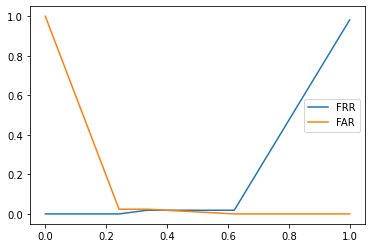

In [ ]:
fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
_filter = threshold <= 1
plt.plot(threshold[_filter], fnr[_filter], label='FRR')
plt.plot(threshold[_filter], fpr[_filter], label='FAR')
plt.legend()
plt.show()

In [ ]:
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('Threshold at the intersection of FRR and FAR:', eer_threshold)
print(f'Equal Error Rate (EER) on valid fold {cfg.fold}:', eer)

Threshold at the intersection of FRR and FAR: 0.3344571
Equal Error Rate (EER) on valid fold 0: 0.023809523809523808


In [ ]:
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('Threshold at the intersection of FRR and FAR:', eer_threshold)
print(f'Equal Error Rate (EER) on valid fold {cfg.fold}:', eer)

Threshold at the intersection of FRR and FAR: 0.6647065
Equal Error Rate (EER) on valid fold 1: 0.019230769230769232
